## 1부 3장 재표본추출 방법

앞에 1장과 2장에서는 단순히 모델을 만드는 방법에 대하여 다루었습니다. 해당 장에서는 앞서 만들어진 모델들이 출력한 결과가 정말 믿을 만한 정보인지 검정하는 방법인 재표본추출 방법에 대하여 배워보겠습니다.

### 3.1 교차검증
교차검증은 모델의 성능을 평가하거나 모델의 유연성을 선택하는데 도움을 줍니다.

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
plt.rc('font', family='Malgun Gothic') # plt 한글깨짐 방지
plt.rcParams['axes.unicode_minus'] = False # plt 마이너스 깨짐 방지

In [36]:
data = pd.read_csv("./data/Auto.csv")
data = data.loc[data["horsepower"] != "?",:].reset_index().drop(columns=["index"])
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    object 
 4   weight        392 non-null    int64  
 5   acceleration  392 non-null    float64
 6   year          392 non-null    int64  
 7   origin        392 non-null    int64  
 8   name          392 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 27.7+ KB


In [39]:
x = data["horsepower"].to_numpy().astype(np.float32).reshape(-1,1)
y = data["mpg"].to_numpy().astype(np.float32).reshape(-1,1)

#### 3.1.1 검증셋 기법

검증셋 기법은 데이터를 일정 비율로 훈련 데이터와 검증 데이터로 나누는 방식을 의미합니다. 나뉘는 비율은 작성자 마음대로 나눌 수 있지만, 일반적으로 (훈련 8 : 검증 2) 의 비율로 나눕니다.

검증셋 기법을 사용하는 이유는 학습 데이터로 훈련을 거친 모델이 출력한 결과가 믿을 만한 결과인지 검증하기 위해서 입니다.

sklearn에서 제공하는 패키지인 ```train_test_split()```을 사용하여 (훈련 8 : 검증 2)의 비율로 나누겠습니다.

In [41]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=20)

선형회귀모델을 적합하는데 전체 데이터의 80%인 훈련 데이터만 모델에 적합시키겠습니다.

In [42]:
model = LinearRegression()
model.fit(x_train,y_train)

LinearRegression()

훈련 데이터에 적합된 모델의 성능을 검증하기 위하여 검증 데이터를 넣어서 확인한 결과 해당 모델은 약 58%의 정확도를 가진다는 것을 알 수 가 있엇습니다.

In [44]:
model.score(x_test,y_test)

0.585637657200264

다른 검증 방법들과 비교하기 위하여 MSE를 구하겠습니다. 검증셋 기법을 사용하여 나온 모델의 MSE는 아래와 같습니다.

In [46]:
mse_1 = np.mean((model.predict(x_test) - y_test) ** 2,axis=0)
print("MSE : %.3f " % mse_1[0])

MSE : 26.901 


#### 3.1.2 LOO(Leave-One-Out) 교차검증

LOO 교차 검증은 이전에 검증셋 기법과 비슷하지만 훈련 데이터의 개수와 검증 데이터의 개수가 다릅니다. 검증 셋 기법의 경우 훈련 데이터와 검증 데이터를 일정 비율로 나누지만 LOO 교차 검증은 검증 데이터를 1개로 두고 남은 데이터를 훈련 데이터로 하여 모델을 적합하는데 아래의 그림과 같이 21번의 모델을 적합시킵니다. 각각의 모델들은 훈련 데이터에 과대적합되어진 좋지 않은 모델이지만 각 모델들의 결과에 평균을 사용하여 과대적합을 방지하고 성능이 더 좋아진 모델이 만들어 집니다.

<img src="https://imgur.com/pp8qHxK.jpg">

sklearn 패키지에서 지원하는 ```LeaveOneOut()```함수를 사용하여 LOO 교차검증 방법을 적용해보겠습니다.

In [52]:
cv = LeaveOneOut()
# enumerate splits
y_true, y_pred = list(), list()
for train_ix, test_ix in cv.split(x):
    # split data
    x_train, x_test = x[train_ix, :], x[test_ix, :]
    y_train, y_test = y[train_ix], y[test_ix]
    # fit model
    model = LinearRegression()
    model.fit(x_train,y_train)
    # evaluate model
    yhat = model.predict(x_test)
    # store
    y_true.append(y_test[0])
    y_pred.append(yhat[0])

int_y_true = np.concatenate([i.astype(np.int32)for i in y_true],axis=0).reshape(-1,1)
int_y_pred = np.concatenate([j.astype(np.int32)for j in y_pred],axis=0).reshape(-1,1)

In [53]:
mse_i = (int_y_pred - int_y_true)**2
cv = np.mean(mse_i ,axis=0)
print("LOO 교차검증이 적용된 평균 MSE : {}".format(cv[0]))

LOO 추정치 : 24.012755102040817


#### 3.1.3 k-fold 교차검증

k-fold 교차검증은 LOO 교차검증과 다르게 검증 데이터의 개수가 더 많습니다. 예를 들어서 아래의 GIF파일과 같이 총 40개의 데이터가 있을 때 이를 4 - fold 교차 검증을 하면 4등분이 된 데이터가 순차적으로 10개의 검증 데이터와 30개의 훈련 데이터로 모델을 적합시키게 됩니다. 그 결과 4개의 모델의 MSE를 구하여 평균을 매기면 K-fold 교차검증 이 적용된 모델의 MSE가 나오게 됩니다.

![Alt Text](https://imgur.com/IDvJHNE.gif)

In [132]:
kf = KFold(n_splits=4)
# enumerate splits
y_true, y_pred = list(), list()
for train_ix, test_ix in kf.split(x):
    # split data
    x_train, x_test = x[train_ix, :], x[test_ix, :]
    y_train, y_test = y[train_ix], y[test_ix]
    # fit model
    model = LinearRegression()
    model.fit(x_train,y_train)
    # evaluate model
    yhat = model.predict(x_test)
    # store
    y_true.append(y_test)
    y_pred.append(yhat)

In [133]:
mse = []
for i in range(len(y_true)):
    mse_i = np.mean(((y_true[i] - y_pred[i]) ** 2),axis=0)
    mse.append(mse_i)
    print("MSE_{} : {}".format(i,mse_i))
mse = np.array(mse)
print("k-fold 추정치 : {}".format(np.mean(mse)))

MSE_0 : [27.62368]
MSE_1 : [27.969906]
MSE_2 : [16.484219]
MSE_3 : [71.446785]
k-fold 추정치 : 35.88114929199219


### 3.2 붓스트랩
붓스트랩은 모집단에서 추출한 표본을 다시 추출하여 붓스트랩 데이터를 만들어 표본의 분포와 표본의 대표성을 검증하는 역할을 하게 됩니다. 붓스트랩이 교차검증과 다른점은 붓스트랩은 중복이 허용된 반복추출을 한다는 점이 있습니다.

<img src="https://imgur.com/F3US8S2.jpg">

붓스트랩이 사용되는 경우
- 붓스트랩은 표본에서 나온 단일 통계치의 신뢰구간을 알고 싶거나 확률변수의 정확한 분포를 모르는 경우 측정된 통계치의 신뢰도를 가늠하기 위해서 사용됩니다. 
- 단순히 표본의 개수가 부족한 경우에도 사용이 됩니다.
- 훈련 데이터셋의 데이터 분포가 고르지 않은 경우에도 사용이 됩니다.
- 파라미터 추정의 정확도 또는 주어진 모델의 정확도를 측정하는데 활용됩니다. 

일반적으로 모집단으로 부터 얻은 표본들로 통계량을 구할 수가 있습니다 예를 들어 한국 남자의 평균 신장을 알고자 하는데 실제로는 모든 한국 남자의 신장을 측정할 수 없으니 일부(N명)을 추출하여 측정하였습니다. 여기서 우리는 N명의 평균 신장을 구할 수 있습니다. 하지만 이 N명의 평균 신장이 정말로 한국 남자 전체의 평균 신장을 대표할 수 있을까요? 이 N명으로 구한 평균 신장이 얼마나 믿을 만한 수치인지 알기 위해서는 표준 오차나 신뢰구간을 구해야 합니다. 

#### 3.2.1 통계량의 정확도 추정

비교하고자 하는 통계량을 정확도를 추정하기 위하여 500개의 임의의 난수를 모집단이라고 하고 500개의 모집단에서 300개의 표본을 중복없이 추출하겠습니다. 붓스트랩 표본으로는 500개의 모집단에서 300개의 표본을 중복을 허용하여 1000번 추출하였을 때의 평균을 구하겠습니다. 구한 결과 단일 표본의 통계량 보다 붓스트랩 표본의 통계량이 모수에 더 가깝게 나왔습니다.

In [22]:
# 모집단 500개
pop = np.random.randint(0,500 , size=1000)
# 표본 300개
sample = np.random.choice(pop, size=300) #so n=300

sample_mean = []
bootstrap_sample = []
# 붓스트랩 표본 10000개
for _ in range(10000):  #so B=10000
    sample_n = np.random.choice(pop, size=300,replace = True)
    sample_mean.append(sample_n.mean())


print("모집단 평균 : {}".format(np.mean(pop)))
print("단일 표본 평균 : {}".format(np.mean(sample)))
print("붓스트랩 평균 : {}".format(np.mean(sample_mean)))

모집단 평균 : 249.869
단일 표본 평균 : 250.44
붓스트랩 평균 : 249.96040233333335


모집단의 평균과 붓스트랩의 평균이 유사하게 나왔습니다. 그렇다면 데이터의 분포도 유사한지 확인하기 위하여 히스토그램을 그려서 비교하겠습니다.

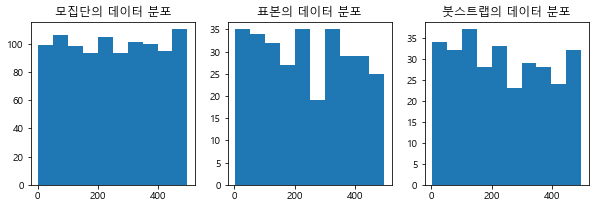

In [16]:
fig, ax = plt.subplots(1,3,figsize=(10,3))
ax[0].hist(pop)
ax[0].set_title("모집단의 데이터 분포")
ax[1].hist(sample)
ax[1].set_title("표본의 데이터 분포")
ax[2].hist(sample_n)
ax[2].set_title("붓스트랩의 데이터 분포")
plt.show()

모집단의 평균과 붓스트랩 표본의 통계량은 유사하였지만 데이터 분포는 단일 표본의 분포와 더 유사하게 나왔습니다. 

#### 3.2.2 모델의 정확도 추정

교차검증에서 사용한 데이터로 단순선형회귀모델을 만들어서 모집단으로 만든 모델, 단일 표본으로 만든 모델, 붓스트랩 표본으로 만들어진 모델들의 MSE를 비교하여 모델의 정확도를 추정하여 보겠습니다.

In [26]:
x = data["horsepower"].to_numpy().astype(np.float32).reshape(-1,1)
y = data["mpg"].to_numpy().astype(np.float32).reshape(-1,1)

model = LinearRegression()
model.fit(x,y)
y_pred = model.predict(x)
pop_mse = np.mean((y - y_pred)**2,axis=0)[0]
print("392개 모집단 회귀모델의 MSE : {}".format(pop_mse))

392개 모집단 회귀모델의 MSE : 23.943660736083984


In [32]:
indices = np.random.choice(len(data),100,replace=False)
sample = data.iloc[indices,:].reset_index().drop(columns=["index"])

x = sample["horsepower"].to_numpy().astype(np.float32).reshape(-1,1)
y = sample["mpg"].to_numpy().astype(np.float32).reshape(-1,1)

model = LinearRegression()
model.fit(x,y)
y_pred = model.predict(x)
sample_mse = np.mean((y - y_pred)**2,axis=0)[0]
print("100개 표본 회귀모델의 MSE : {}".format(sample_mse))

100개 표본 회귀모델의 MSE : 20.868268966674805


In [33]:
bootstrap_mse = []
for _ in range(1000):
    indices = np.random.choice(len(data),100,replace=True)
    bootstrap = data.iloc[indices,:].reset_index().drop(columns=["index"])
    
    x = bootstrap["horsepower"].to_numpy().astype(np.float32).reshape(-1,1)
    y = bootstrap["mpg"].to_numpy().astype(np.float32).reshape(-1,1)
    
    model = LinearRegression()
    model.fit(x,y)
    y_pred = model.predict(x)
    mse = np.mean((y - y_pred)**2,axis=0)[0]
    bootstrap_mse.append(mse)
    
bootstrap_mse = np.array(bootstrap_mse).mean(axis=0)
print("1000개 붓스트랩 회귀모델의 평균 MSE : {}".format(bootstrap_mse))

1000개 붓스트랩 회귀모델의 평균 MSE : 23.339004516601562


1000개의 붓스트랩 회귀모델의 평균 MSE가 모집단 회귀모델의 MSE와 굉장히 유사하기에 단일 표본 회귀모델보다 잘 적합되었다고 볼 수 있습니다.